# Seasonal forecast download and plot for one coordinate

### About

This notebook is based on "Seasonal Forecast Anomalies": https://ecmwf-projects.github.io/copernicus-training-c3s/sf-anomalies.html
It was mainly modified to use daily resolution instead of monthly.
It provides a practical introduction to calculating seasonal forecast with data from the Copernicus Climate Change Service (C3S). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this tutorial we shall focus on the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access real-time forecast data of total precipitation, with a forecast start date in May 2023 and 6-7 monthly lead times (up to October 2023). Hindcast data for the same start date and lead-time months in the reference period 1993 to 2016 will also be downloaded. 

The tutorial will then show how to interpolate in a coordinate for both the forecast and hindcast data. (The climate mean for the reference period will be computed and this reference mean will be subtracted from the real-time forecast data to derive monthly anomalies BORRAR?). These will be visualised as time series. Finally, 3-monthly anomalies will be calculated and visualised in an interactive plot, as a demonstration of how to reproduce similar [charts available through C3S](https://climate.copernicus.eu/charts/c3s_seasonal/).


The notebook has the following outline:
* 1 - Process seasonal hindcast grib files (6h, air temperature)
* 2 - Export seasonal hindcast csv files (daily mean temperature)
* 3 - Real-time forecasts

<br>

<hr>

### Install packages

In [6]:
# Install CDS API for downloading data from the CDS
#!pip install cdsapi

In [2]:
# Install cfgrib to enable us to read GRIB format files
#!conda install -c conda-forge cfgrib -y

In [1]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

# 1 - Process seasonal hindcast grib files (6h, air temperature)

<hr>

In [1]:
# Define the coordinates to interpolate to
interp_longitude=2.25 #reach1=reach2=2.25
interp_latitude=42.05  #reach1=42.3, reach2=42.05
variable_name = '2m_temperature'
var_short = 't2m'
forecast_year = 2024

Here we specify a data directory in which the grib files are located

In [3]:
DATADIR = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal'

Obtaining daily mean temperature data sets

In [7]:
hind_all = []

for month_num in range(1,13):
    
    #month_num = 1

    hind_1 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_1993-2003_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
    hind_2 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2004-2014_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')
    hind_3 = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2015-2016_'+ str(month_num) + '_hindcast_daily_' + var_short + '.grib', engine='cfgrib')

    hind_var_1 = hind_1[var_short]
    hind_var_2 = hind_2[var_short]
    hind_var_3 = hind_3[var_short]

    #data_array= hind_var_1
    #summary_stats = {
    #    'mean': data_array.mean(),
    #    'min': data_array.min(),
    #    'max': data_array.max(),
    #    'std': data_array.std(),
    #    'median': data_array.median(),
    #}

    # Interpolate the values for the specified coordinates
    hind_interp_1 = hind_var_1.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
    hind_interp_2 = hind_var_2.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
    hind_interp_3 = hind_var_3.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

    daily_step_1 = int(hind_interp_1.sizes['step']/4)
    daily_step_2 = int(hind_interp_2.sizes['step']/4)
    daily_step_3 = int(hind_interp_3.sizes['step']/4)

    hind_daily_1 = hind_interp_1.groupby_bins('step', bins=daily_step_1).mean()
    hind_daily_2 = hind_interp_2.groupby_bins('step', bins=daily_step_2).mean()
    hind_daily_3 = hind_interp_3.groupby_bins('step', bins=daily_step_3).mean()

    hind_merged = xr.concat([hind_daily_1, hind_daily_2, hind_daily_3], dim='time')
    hind_all.append(hind_merged)
    
    

Save data to npy file (one per subcatchment C1, C2)

In [8]:
from copy import deepcopy
hind_all_t2m = np.empty(1,dtype=object)
hind_all_t2m[0] = deepcopy(hind_all)
np.save('hind_all_t2m_C2',hind_all_t2m) #change _C1 or C2 accordingly.

# 2 - Export seasonal hindcast csv files (daily mean temperature)

Import npy file to create hind files for each year, month and member

In [2]:
#data = np.load('hind_all_t2m.npy',allow_pickle=True)
hind_all = (np.load('hind_all_t2m_C2.npy',allow_pickle=True))[0]   ##change _C1 or C2 accordingly
hind_all

[<xarray.DataArray 't2m' (number: 25, time: 24, step_bins: 215)>
 array([[[271.2848 , 270.95438, 269.77954, ..., 292.4043 , 292.38052,
          292.22174],
         [274.61072, 277.38336, 277.83893, ..., 294.8559 , 295.68744,
          296.0791 ],
         [274.9697 , 269.1538 , 268.75293, ..., 293.74933, 292.7959 ,
          289.99655],
         ...,
         [276.54776, 278.4737 , 281.44595, ..., 289.34   , 289.50595,
          289.09692],
         [271.4522 , 275.3647 , 276.93442, ..., 291.13184, 290.30994,
          289.0232 ],
         [278.88403, 277.27676, 274.40573, ..., 300.19836, 300.05234,
          298.39362]],
 
        [[271.1648 , 271.60544, 269.8734 , ..., 291.38605, 291.26257,
          292.43152],
         [274.5905 , 277.30457, 278.02353, ..., 290.8925 , 291.29095,
          292.41428],
         [274.69708, 270.6906 , 270.05826, ..., 290.66394, 292.0235 ,
          293.76477],
 ...
         [276.6223 , 278.3533 , 280.43524, ..., 293.23395, 291.91885,
          291.5

In [50]:
#exploring npy file
print(type(hind_all))
print(len(hind_all))

<class 'list'>
12


In [6]:
# Set path to save hind files
save_path = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/seasonal/hindcast'

In [7]:
# Define a function to save each sub-array
def save_sub_array(dataarray, number, time, list_idx, save_path):
    
    # Extract the sub-array
    sub_array = dataarray.sel(number=number, time=time).values
    # Check the extracted sub-array
    #print(f"Extracted sub-array for number {number}, time {time}:", sub_array)
    
    # Convert the temperature from Kelvin to Celsius
    sub_array_celsius = sub_array - 273.15
    # Check the converted sub-array
    #print(f"Converted sub-array for number {number}, time {time}:", sub_array_celsius)
    
    # Define the filename
    filename = os.path.join(save_path,f"hind_C2_t2m_member{number}_year{time}_month{list_idx}.csv") #change _C1 or C2 accordingly
    
    # Convert the sub-array to a DataFrame
    df = pd.DataFrame(sub_array_celsius)
    #print(f"DataFrame to be saved for number {number}, time {time}:")
    #print(df.head())

    # Save the DataFrame to a .csv file
    np.savetxt(filename, df.values, delimiter=',', fmt='%.6f')
    #print(f"Saved {filename}") 

# Iterate through the list
for list_idx, data in enumerate(hind_all):
    # Convert each element to an xarray.DataArray
    dims = ['number', 'time', 'step_bins']
    coords = {
        'number': np.arange(data.shape[0]),
        'time': np.arange(data.shape[1]),
        'step_bins': np.arange(data.shape[2])
    }
    dataarray = xr.DataArray(data, dims=dims, coords=coords)
    
    # Iterate through each 'number' and 'time'
    for number in dataarray.coords['number'].values:
        for time in dataarray.coords['time'].values:
            save_sub_array(dataarray, number, time, list_idx, save_path)
            

Plotting to verify datasets

In [ ]:
#plot all members of the same month and year
# Function to load data files for a specific time and list_idx (month)
def load_temperature_data(list_idx, time, save_path, prefix="hind_C1"): #change _C1 or C2 accordingly
    combined_data = []

    # Iterate over all members (number from 0 to 24)
    for number in range(25):
        filename = f"{prefix}_t2m_month{list_idx}_member{number}_year{time}.csv" 
        file_path = os.path.join(save_path, filename)
        
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            combined_data.append(data)
        else:
            print(f"File not found: {file_path}")

    return np.array(combined_data)

# Function to plot the combined data
def plot_temperature_data(combined_data, list_idx, time):
    plt.figure(figsize=(10, 5))

    # Plot each member's data
    for member_data in combined_data:
        plt.plot(member_data, color='gray', alpha=0.5)
        
    # Calculate mean temperature across all members
    mean_temperature = np.mean(combined_data, axis=0)
    
    # Plot the mean temperature in black line
    plt.plot(mean_temperature, color='black', linewidth=2)

    plt.title(f'Air Temperature for all members for Month {list_idx} and Year {time}')
    plt.xlabel('Days')
    plt.ylabel('Air Temperature (°C)')
    plt.show()

# Specify the month (list_idx) and time (year) you want to plot
list_idx_to_plot = 0  # Month 0-11
time_to_plot = 1      # Year 0-23

# Load the data for the specified month and year
combined_data = load_temperature_data(list_idx_to_plot, time_to_plot, save_path)

# Plot the combined data
plot_temperature_data(combined_data, list_idx_to_plot, time_to_plot)

Now we should opne ERA5 to add it before the season to run the hydrological model

## 3. Real time seasonal forecasts (I DIDNT CHANGE/USE ANYTHING ON THIS SECTION)

The next step is to load the real-time seasonal forecast data for 6 lead time months. (BORRAR?) We will then subtract the hindcast climatology from this to derive the anomalies. 


In [137]:
fore = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_'+ str(forecast_year) + '_' + str(month_num) + '_forecast_daily_' + var_short + '.grib', engine='cfgrib')

In [138]:
fore_var = fore[var_short]

#### Convert forecast lead time month into dates (AUN NO)


In [140]:
# Interpolate the values for the specified coordinates
fore_interp = fore_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

In [143]:
num_members = len(fore_interp)
daily_step = fore_interp.sizes['step']/4
fore_daily = fore_interp.groupby_bins('step', bins=daily_step).mean()

/home/daniel/.local/lib/python3.12/site-packages/xarray/core/groupby.py:581: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  binned, self.bins = pd.cut(data, self.bins, **self.cut_kwargs, retbins=True)


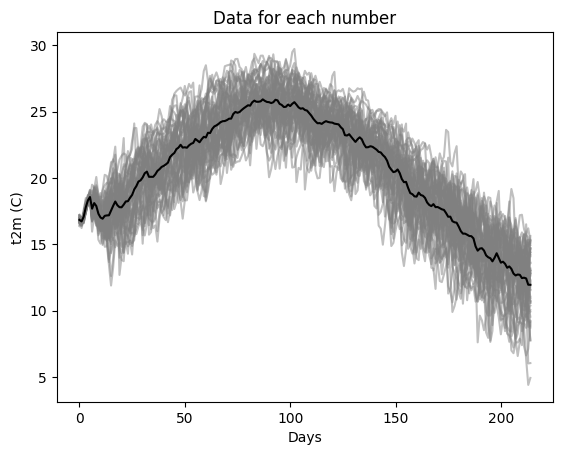

In [147]:
for i in range(num_members):
    # Select the subset of data for the current number
    subset = fore_daily.sel(number=i)-273.15
    
    # Plotting
    plt.plot(subset, color='gray', alpha=0.5, label=f'Number {i}')

#plot average in black
plt.plot(fore_daily.mean(dim='number')-273.15, color='black')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('t2m (C)')
plt.title('Data for each number')
#plt.legend()  # Add legend to differentiate lines
plt.show()
